# Introduction


My baseline builds on the `4lang` project available on github: [Link](https://github.com/kornai/4lang).
Our idea was to use the concept of the 4lang graphs discussed in paper: [Link](http://real.mtak.hu/46059/1/324_Paper.pdf)

In this notebook I only present the client side of our baseline, the code of the webservice built from the 4lang system will be available soon as well. I will present a simple way of using the 4lang graphs for inference. For this task we can calculate similarities among the graphs edges built from the premise and the hypothesis sentences.

Let's say we have a __premise__ sentence:

`My poor wife!`

and a __hypothesis__ sentence:

`I feel bad for my wife!`

then we can run the text_to_4lang tool to generate the graphs from the sentences. From these sentences we generate the following graphs:


    premise:
![premise](https://raw.githubusercontent.com/recski/semantic_parsing_szte_bme/master/nli_baselines/Adam/images/127045eprem.png?token=AVWz9SbmWEjLvRdxL7i97HnVMq_s5L8Uks5aqXtswA%3D%3D)

    hypothesis:
![hypothesis](https://raw.githubusercontent.com/recski/semantic_parsing_szte_bme/master/nli_baselines/Adam/images/127045ehyp.png?token=AVWz9S9oIgSX1bmdogWvCXoihpt8G-wxks5aqXuVwA%3D%3D)

From the sentences we can already have an anticipation that these sentences are very similar, so the __hypothesis__ sentence will be an __entailment__ . So if we are ready to make an assumption an inference corresponds with the similarity of the graphs's edges, than in this case the graphs tells us that this is indeed an __entailment__ . 


This simple method works for a lot of examples, but if we want higher accuracy, we need to define finer techniques. This is where the definitions of the words come into play.


Currently our service has six endpoints, with each of them representing different methods:
- `<url>/pair/<Id>` - Returns the graphs built from the sentences.
- `<url>/pair_expand/<Id>` - Returns the graphs, where the word's definition has been added to the graph.
- `<url>/pair_abstract/<Id>` - Calling this function, we defined some rules, where we can build a more abstract graph using the definitions.
- `<url>/sym/<Id>` - Returns the similarity between two graphs.
- `<url>/sym_expand/<Id>` - Returns the similarity between two expanded graphs.
- `<url>/sym_abstract/<Id>` - Returns the similarity between two abstracted graphs.


In [161]:
import json

In [1]:
import requests

In [ ]:
'''
First, to show how the service works we process the nli data to get the sentences and the corresponding gold labels(to simplify
things we reduce the task to a binary classification where we want to distinguish "neutral" and "entailment" sentences.)
'''
with open("multinli_1.0_train.jsonl", "r+") as f:
    labels = {}
    hypothesis = {}
    premise = {}
    count = 0
    for line in f:
        if count == 5000:
            break
        count = count + 1
        j = json.loads(line)
        if j["gold_label"] == "entailment" or j["gold_label"] == "neutral":
            pairId = j["pairID"]
            labels[pairId] = j["gold_label"]
            premise[pairId] = j["sentence1"]
            hypothesis[pairId] = j["sentence2"]

In [163]:
'''
Say we have the following sentence pairs, and we want to compute if it is an entailment or not.
'''
print(premise['117000e'])
print(hypothesis['117000e'])

And in between, you'll come upon the historic towns of Toulouse, Albi, and Montpellier.
You will pass through the historic towns of Toulouse, Albi, and Montpellier on your way to the final destination.


In [37]:
'''
The first request gets the similarity between the expanded graphs build from the sentences and the second works only
with the above defined default graphs, we can see that there are higher score if we expand our graph with the definition graph.
'''
urldot = url + 'pairexp/' + '117000e'
requests.get(urldot)
urlsim = url + 'symexp/' + '117000e'
pred = requests.get(urlsim)
print(pred.json())

urldot = url + 'pair/' + '117000e'
requests.get(urldot)
urlsim = url + 'sym/' + '117000e'
pred = requests.get(urlsim)
print(pred.json())

0.352941176471
0.3125


# Expanded Graphs

We said we wanted higher accuracy, so we take word definitions into account. We hope that with this method we can have higher similarites between graphs whose sentences are also similar. Let's look at the __premise__ sentence discussed in the introduction section:

`My poor wife!`

    and the corresponding graph:

![premise](https://raw.githubusercontent.com/recski/semantic_parsing_szte_bme/master/nli_baselines/Adam/images/127045eprem.png?token=AVWz9cAjAw2eVzIMr7KU3gpyphEbJtvyks5aqXuzwA%3D%3D)

if we know that the word __poor__ definition is : _having very little money and not many possessions_ we can build a definition graph and essentially join the two graphs together doing this for every word in the sentence:

![expanded](https://raw.githubusercontent.com/recski/semantic_parsing_szte_bme/master/nli_baselines/Adam/images/127045eprem_expand.png?token=AVWz9ddpVV03hw-YhfwZg8aiddNANhv_ks5aqXvGwA%3D%3D)

this way the expanded graph gives us much more accurat context and definition.

In [164]:
'''
It's our task to set a threshold to what we consider an entailment, I initialized a list with different scores, so we can have a
more accurat look at the results
'''
support = [0.03, 0.06, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
'''
First we initialize our graphs, so we can efficiently work with them later
'''
def init_graphs():
    with open("multinli_1.0_train.jsonl", "r+") as f:
    count = 0
    for line in f:
        if count == 5000:
            break
        count = count + 1
        print(count)
        j = json.loads(line)
        if j["gold_label"] == "entailment" or j["gold_label"] == "neutral":
            pairId = j["pairID"]
            urldot = url + 'pair/' + pairId
            requests.get(urldot)
            urlexp = url + 'pairexp/' + pairId
            requests.get(urlexp)
            urlabs = url + 'pair_abstract/' + pairId
            requests.get(urlabs)

In [66]:
'''
We process our data and get the gold labels to the y_true list, after that we call our webservice to return the predicted score
calculated on the default graphs
'''
def return_scores(supportscore):
    with open("multinli_1.0_train.jsonl", "r+") as f:
        labels = {}
        hypothesis = {}
        premise = {}
        y_true = []
        y_pred = []
        count = 0
        for line in f:
            if count == 5000:
                break
            count = count + 1
            print(count)
            j = json.loads(line)
            if j["gold_label"] == "entailment" or j["gold_label"] == "neutral":
                pairId = j["pairID"]
                labels[pairId] = j["gold_label"]
                premise[pairId] = j["sentence1"]
                hypothesis[pairId] = j["sentence2"]
                if j["gold_label"] == "entailment":
                    y_true.append(1)
                elif j["gold_label"] == "neutral":
                    y_true.append(0)                
                
                urlsim = url + 'sym/' + pairId
                pred = requests.get(urlsim)
                if float(pred.json()) > supportscore :
                    y_pred.append(1)
                else:
                    y_pred.append(0)
                
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    return [accuracy, precision, recall, f1_score, y_pred.count(1)]

In [42]:
'''
Essentially the same as above, only on expanded graphs.
'''
def return_expanded_scores(supportscore):
    with open("multinli_1.0_train.jsonl", "r+") as f:
        labels = {}
        hypothesis = {}
        premise = {}
        y_true = []
        y_pred_exp = []
        count = 0
        for line in f:
            if count == 5000:
                break
            count = count + 1
            print(count)
            j = json.loads(line)
            if j["gold_label"] == "entailment" or j["gold_label"] == "neutral":
                pairId = j["pairID"]
                labels[pairId] = j["gold_label"]
                premise[pairId] = j["sentence1"]
                hypothesis[pairId] = j["sentence2"]
                if j["gold_label"] == "entailment":
                    y_true.append(1)
                elif j["gold_label"] == "neutral":
                    y_true.append(0)                
                
                urlsimexp = url + 'symexp/' + pairId
                pred = requests.get(urlsimexp)
                if float(pred.json()) > supportscore :
                    y_pred_exp.append(1)
                else:
                    y_pred_exp.append(0)
                
    accuracy = accuracy_score(y_true, y_pred_exp)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_exp, average='binary')
    
    return [accuracy, precision, recall, f1_score, y_pred_exp.count(1)]

# Abstract graphs

If we go back to the __premise__ sentence discussed above, and get the expanded graph:

![expanded](https://raw.githubusercontent.com/recski/semantic_parsing_szte_bme/master/nli_baselines/Adam/images/127045eprem_expand.png?token=AVWz9bpcYOzTm6pkSbmIBqHIPIYF63cNks5aqXv2wA%3D%3D)

In this example if we look at the edge __wife__ --> __woman__ with __label__:0 we can make an assumption that within the boundaries of the sentence we can use the concept __woman__ instead of the concept __wife__ . Using this simple rule we can reduce our graph to a simpler definition:

![abstract](https://raw.githubusercontent.com/recski/semantic_parsing_szte_bme/master/nli_baselines/Adam/images/127045eprem_abstract.png?token=AVWz9WTJIy_Q53Yw1uHAqGlDTppnhlOnks5aqXwCwA%3D%3D)

Following this logic we initially made three simple rules:

If we have a machine, and its definition graphs, where:
- Def --> X is present with label: 0 than we can use X instead of Def machine
- X --> Def is present with label: 0 than we can use X instead of Def machine again.
- If we have Y <-- Def --> X with labels: 1,2 both in the definition and the sentence graph, than we can connect every edge from X and Y from the definition graph to the sentence graph

For the third rule:

Let's have the following graph:

![default](https://raw.githubusercontent.com/recski/semantic_parsing_szte_bme/master/nli_baselines/Adam/images/default.png?token=AVWz9S07jZP6px8Fskl7hWqyQKMpXpUSks5aqXwLwA%3D%3D)

and say we have the definition of the concept __increase__ in the following graph:

![increase](https://raw.githubusercontent.com/recski/semantic_parsing_szte_bme/master/nli_baselines/Adam/images/expanded.png?token=AVWz9VbbwjErL8MM7JPvzKheh8-CGRrbks5aqXwUwA%3D%3D)

than by the rule number 3 we can add the following additional edges to the __price__ concept:

![price](https://raw.githubusercontent.com/recski/semantic_parsing_szte_bme/master/nli_baselines/Adam/images/abstract.png?token=AVWz9QmeULS5jMYCn7VtTnvcQ-wCBuz9ks5aqXwdwA%3D%3D)

In [10]:
'''
In this method we defined, how we return the similarity score, it has a single argument, the threshold value
(because We only want to test our methods, I only used a test sample of 5000 sentences). After we calculated the similarity scores
we return f1-score, precision, recall and the accuracy.
'''
def return_abstract_scores(supportscore):
    with open("multinli_1.0_train.jsonl", "r+") as f:
        labels = {}
        hypothesis = {}
        premise = {}
        y_true = []
        y_pred_abs = []
        count = 0
        for line in f:
            if count == 5000:
                break
            count = count + 1
            print(count)
            j = json.loads(line)
            if j["gold_label"] == "entailment" or j["gold_label"] == "neutral":
                pairId = j["pairID"]
                labels[pairId] = j["gold_label"]
                premise[pairId] = j["sentence1"]
                hypothesis[pairId] = j["sentence2"]
                if j["gold_label"] == "entailment":
                    y_true.append(1)
                elif j["gold_label"] == "neutral":
                    y_true.append(0)                
                
                urlsimexp = url + 'sym_abstract/' + pairId
                pred = requests.get(urlsimexp)
                if float(pred.json()) > supportscore :
                    y_pred_abs.append(1)
                else:
                    y_pred_abs.append(0)
                
    accuracy = accuracy_score(y_true, y_pred_abs)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_abs, average='binary')
    
    return [accuracy, precision, recall, f1_score, y_pred_exp.count(1)]

In [67]:
#Importing pyplot, and calling the default scores function, and we draw a simple diagram from the results
from matplotlib import pyplot as plt

accuracies = []
precisions = []
recals = []
f1_scores = []
entailments = []

for i in support:
    scores = return_scores(i)
    accuracies.append(scores[0])
    precisions.append(scores[1])
    recals.append(scores[2])
    f1_scores.append(scores[3])
    entailments.append(scores[4])


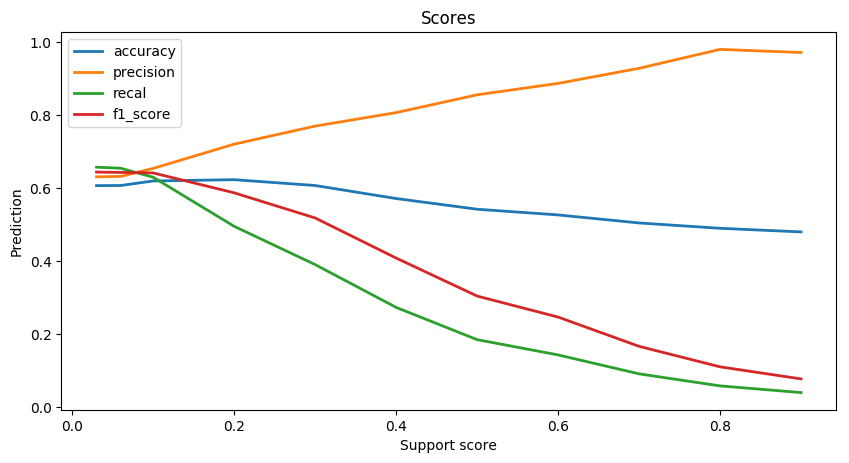

In [70]:
#Plotting to our canvas
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.plot(support,accuracies,label='accuracy',linewidth=2)
plt.plot(support,precisions,label='precision',linewidth=2)
plt.plot(support,recals,label='recal',linewidth=2)
plt.plot(support,f1_scores,label='f1_score',linewidth=2)

plt.legend()

plt.title('Scores')
plt.xlabel('Support score')
plt.ylabel('Prediction')

#Showing what we plotted, we can see we achieved pretty good values with ~0,62 f1_score and accuracy
#Interesting thing to notice is that if we had some edge similarity, raising the threshold value doesnt change the result.
plt.show()

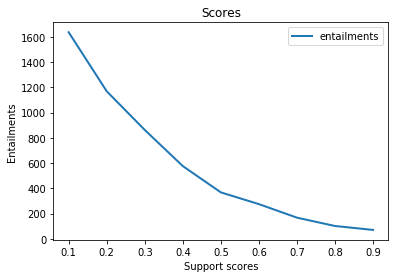

In [57]:
plt.plot(support,entailments,label='entailments',linewidth=2)
plt.legend()

plt.title('Scores')
plt.xlabel('Support scores')
plt.ylabel('Entailments')

plt.show()

In [ ]:
#We are doing the same as above just only for expanded graphs. We achieved better results with this method, with f1_score
#coming near to ~0.7 percent.
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
accuracies_exp = []
precisions_exp = []
recals_exp = []
f1_scores_exp = []
entailments_exp = []

for i in support:
    scores = return_expanded_scores(i)
    accuracies_exp.append(scores[0])
    precisions_exp.append(scores[1])
    recals_exp.append(scores[2])
    f1_scores_exp.append(scores[3])
    entailments_exp.append(scores[4])

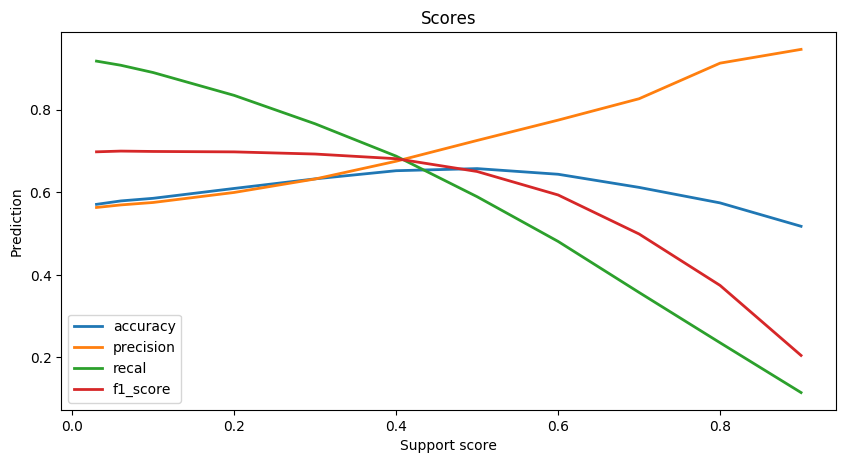

In [46]:
from matplotlib import pyplot as plt
#Plotting to our canvas
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.plot(support,accuracies_exp,label='accuracy',linewidth=2)
plt.plot(support,precisions_exp,label='precision',linewidth=2)
plt.plot(support,recals_exp,label='recal',linewidth=2)
plt.plot(support,f1_scores_exp,label='f1_score',linewidth=2)

plt.legend()

plt.title('Scores')
plt.xlabel('Support score')
plt.ylabel('Prediction')

#Showing what we plotted
plt.show()

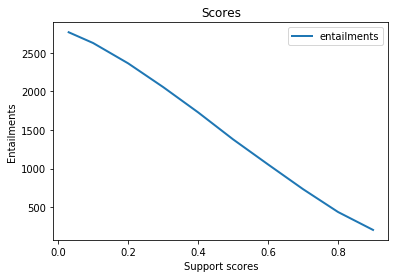

In [47]:
plt.plot(support,entailments_exp,label='entailments',linewidth=2)
plt.legend()

plt.title('Scores')
plt.xlabel('Support scores')
plt.ylabel('Entailments')

plt.show()

In [ ]:
#Doing the same for abstracted graphs, it is only a test result, because here the graphs only used the first rule.
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
accuracies_abs = []
precisions_abs = []
recals_abs = []
f1_scores_abs = []
entailments_abs = []

for i in support:
    scores = return_abstract_scores(i)
    accuracies_abs.append(scores[0])
    precisions_abs.append(scores[1])
    recals_abs.append(scores[2])
    f1_scores_abs.append(scores[3])
    entailments_abs.append(scores[4])

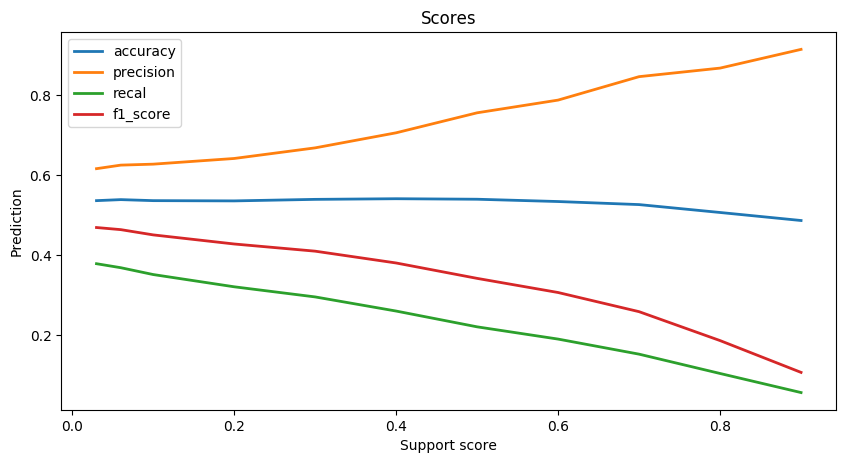

In [12]:
from matplotlib import pyplot as plt
#Plotting to our canvas
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.plot(support,accuracies_abs,label='accuracy',linewidth=2)
plt.plot(support,precisions_abs,label='precision',linewidth=2)
plt.plot(support,recals_abs,label='recal',linewidth=2)
plt.plot(support,f1_scores_abs,label='f1_score',linewidth=2)

plt.legend()

plt.title('Scores')
plt.xlabel('Support score')
plt.ylabel('Prediction')

#Showing what we plotted
plt.show()

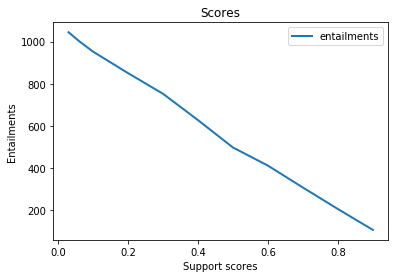

In [13]:
plt.plot(support,entailments_abs,label='entailments',linewidth=2)
plt.legend()

plt.title('Scores')
plt.xlabel('Support scores')
plt.ylabel('Entailments')

plt.show()

# ONLY TESTING SOME SMALL EXAMPLES

In [11]:
url = 'http://127.0.0.1:5000/'
inp = ['93208e', '102167e', '30868n', '119952e', '141334n', '50602n', '134042e', '20566e', '33940n','33940n','52785e',
       '120818n', '50720e', '139990e', '43516n', '31012e', '99278n', '125407n', '18015n', '103287e', '81497e', '39339n']
inp2 = ['102167e']
for i in inp:
    urlsim = url + 'pair_abstract/' + i
    pred = requests.get(urlsim)

In [14]:
import json
with open("multinli_1.0_train.jsonl", "r+") as f:
    labels = {}
    hypothesis = {}
    premise = {}
    y_true = []
    y_pred = []
    small_sentences = []
    count = 0
    for line in f:
        if count == 5000:
            break
        count = count + 1
        j = json.loads(line)
        if j["gold_label"] == "entailment" or j["gold_label"] == "neutral":
            pairId = j["pairID"]
            labels[pairId] = j["gold_label"]
            premise[pairId] = j["sentence1"]
            hypothesis[pairId] = j["sentence2"]
            if j["gold_label"] == "entailment":
                y_true.append(1)
            elif j["gold_label"] == "neutral":
                y_true.append(0)
            if len(premise[pairId].split()) < 7 and len(hypothesis[pairId].split()) < 7:
                small_sentences.append(pairId)

In [159]:
print(premise['127045e'])
print(hypothesis['127045e'])

My poor wife! 
I feel bad for my wife!


In [156]:
inp = ['19833e',
'7479e',
'85687e',
'98513e',
'141786e',
'18626e',
'116210e',
'41414e',
'91281e',
'127045e']

In [158]:
url = 'http://127.0.0.1:5000/'
for i in inp:
    urlsim = url + 'pair_abstract/' + i
    pred = requests.get(urlsim)

In [142]:
print(premise['19833e'])
print(hypothesis['19833e'])

The next witness was Mary Cavendish. 
There was another witness.


In [120]:
url = 'http://127.0.0.1:5000/'
for i in inp:
    urlabs = url + 'sym_abstract/' + i
    urlexp = url + 'symexp/' + i
    urlsim = url + 'sym/' + i
    predabs = requests.get(urlabs)
    predsim = requests.get(urlsim)
    predexp = requests.get(urlexp)
    print("pred_abs:" + i)
    print(predabs.json())
    print("pred_sim:" + i)
    print(predsim.json())
    print("pred_exp:" + i)
    print(predexp.json())

pred_abs:19833e
0.45
pred_sim:19833e
0
pred_exp:19833e
0.571428571429
pred_abs:7479e
0
pred_sim:7479e
0
pred_exp:7479e
0
pred_abs:85687e
0.953488372093
pred_sim:85687e
0
pred_exp:85687e
0.736842105263
pred_abs:98513e
0.2
pred_sim:98513e
0.333333333333
pred_exp:98513e
0.0769230769231
pred_abs:141786e
0
pred_sim:141786e
0
pred_exp:141786e
0
pred_abs:18626e
0.310344827586
pred_sim:18626e
0
pred_exp:18626e
0.2
pred_abs:116210e
0.105263157895
pred_sim:116210e
0
pred_exp:116210e
0
pred_abs:41414e
0.454545454545
pred_sim:41414e
0
pred_exp:41414e
0.333333333333


In [144]:
url = 'http://127.0.0.1:5000/'
for i in ['19833e']:
    urlsim = url + 'pairexp/' + i
    pred = requests.get(urlsim)